In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
np.set_printoptions(threshold=np.inf)
# vehicle verify --specification Superclass/superclass.vcl --network classifier:Superclass/models/model.onnx --parameter epsilon:0.0001 --dataset images:dataset/images.idx --dataset labels:dataset/labels.idx --verifier Marabou

In [ ]:
from dataset import get_data
_N = 32
batch_size = 99999
mean = 0.3211
std = 0.2230
PATH,LABELS,normalise,GROUPS,GROUP_NAMES,n_classes,train_loader,test_loader = get_data(_N,batch_size)

In [3]:
_images = []
_labels = []

for image,label in train_loader:
    size = len(label)
    _images.extend(torch.Tensor.numpy(image.reshape((size,_N,_N)),force=True))
    _labels.extend(torch.Tensor.numpy(label,force=True))

In [4]:
images = np.array(_images,dtype=np.float64)
labels = np.array(_labels,dtype=np.uint8)
groups = np.array([GROUPS[i] for i in labels])

In [5]:
print(labels.shape)
print(images.shape)

(9456,)
(9456, 32, 32)


6


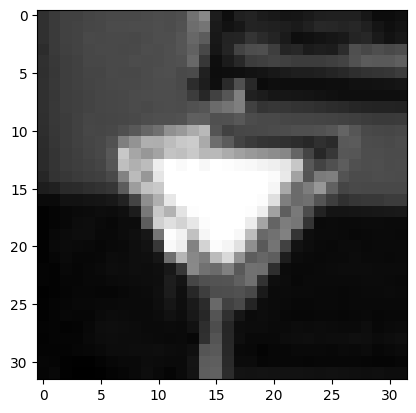

In [6]:
plt.imshow(images[1500],cmap="gray")
print(labels[1500])

In [ ]:
def image_to_vnn(img,epsilon):
    upperBounds = normalise(torch.ones(1,1,1,1)).item()
    lowerBounds = normalise(torch.zeros(1,1,1,1)).item()
    # epsilonBound = epsilon / std
    lower = img - epsilon # NORMALISE EPSILON PLEASE
    upper = img + epsilon

    lower = np.clip(lower,a_min=lowerBounds,a_max=upperBounds)
    upper = np.clip(upper,a_min=lowerBounds,a_max=upperBounds)

    lower = lower.reshape(_N * _N)
    upper = upper.reshape(_N * _N)



In [ ]:
def write_idx(imgs,labels,n): # Pull n examples per class to create the idx dataset from
    # images are saved normalized
    imgs = imgs.reshape(imgs.shape[:3])
    frequency = np.zeros(shape=n_classes)
    save_imgs = np.zeros((n*n_classes,_N,_N),dtype=np.float64)
    save_labels = np.zeros(n*n_classes,dtype=np.uint8)
    counter = 0
    for img,label in zip(imgs,labels):
        if frequency[label] >= n:
            continue
        frequency[label] += 1
        save_imgs[counter] = img
        save_labels[counter] = label
        counter += 1

    path = Path("../dataset") 
    save_labels = np.array([GROUPS[i] for i in save_labels],dtype=np.uint8)
    print(frequency)
    idx2numpy.convert_to_file(str(path / "images.idx"),save_imgs)
    idx2numpy.convert_to_file(str(path / "labels.idx"),save_labels)
write_idx(images,labels,2)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


(24, 32, 32)
>f8
(24,)
uint8
[0 0 0 2 2 0 2 2 0 2 2 1 0 1 1 0 0 2 1 1 1 1 1 2]
Other Prohibitory Signs


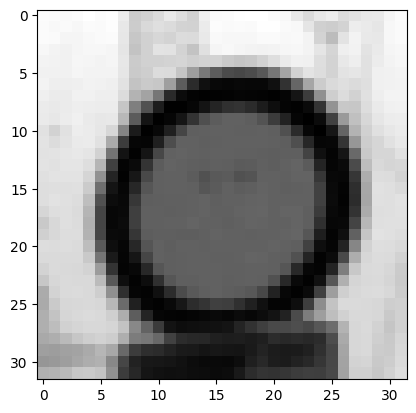

In [11]:
def func():
    # Reading
    path = Path("../dataset")
    i = 6
    ndarr = idx2numpy.convert_from_file(str(path / "images.idx"))
    print(ndarr.shape)
    print(ndarr.dtype)
    plt.imshow(ndarr[i],cmap="gray") # 20 30 50 60
    ndarr = idx2numpy.convert_from_file(str(path / "labels.idx"))
    print(ndarr.shape)
    print(ndarr.dtype)
    print(ndarr)
    print(GROUP_NAMES[ndarr[i]])
func()